# **Deep Learning 개별 프로젝트**
## chest X-ray 데이터 폐렴 환자 분류하기
- Chest X-ray(Pneumonia) 데이터 활용 (5,863장)
- 2 categories (Pneumonia/Normal)
- 자료 출처 : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

- 수행할 작업: 데이터 부풀리기 / 이미지 센터링 / 모델의 변화

#### **파일 경로 불러오기**

In [2]:
dir_path = '/content/drive/MyDrive/dataset/chest_xray/'

In [3]:
train_dir = dir_path+'train/'
test_dir = dir_path+'test/'
validation_dir = dir_path+'val/'
train_normal_dir = train_dir+'NORMAL/'
train_pneumonia_dir = train_dir+'PNEUMONIA/'
test_normal_dir = test_dir+'NORMAL/'
test_pneumonia_dir = test_dir+'PNEUMONIA/'
val_normal_dir = validation_dir+'NORMAL/'
val_pneumonia_dir = validation_dir+'PNEUMONIA/'

In [ ]:
# 파일 이름
import os
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)
test_normal_fnames = os.listdir(test_normal_dir)
test_pneumonia_fnames = os.listdir(test_pneumonia_dir)
validation_normal_fnames = os.listdir(val_normal_dir)
validation_pneumonia_fnames = os.listdir(val_pneumonia_dir)

print(train_normal_fnames[:2])
print(train_pneumonia_fnames[:2])

#### **파일 개수 확인**

In [7]:
# train_normal: 1349장 / train_pneumonia:3884장 / test: 234장 / test_pneumonia: 390장 / val : 각각 8장씩 들어있음
len(train_normal_fnames), len(train_pneumonia_fnames), len(test_normal_fnames), len(test_pneumonia_fnames), len(validation_normal_fnames), len(validation_pneumonia_fnames)

(1349, 3884, 234, 390, 8, 8)

- normal의 훈련 데이터셋 개수가 적음.
- Data augmentation을 통해 데이터를 부풀린 후 모델 학습을 진행하고자 함.

- 데이터 부풀리기를 진행하는 이유 : 훈련셋이 부족하거나 시험셋의 특성을 충분히 반영하지 못하는 경우, 모델의 성능이 떨어지기 때문에 훈련셋의 개수를 의도적으로 늘려 모델의 성능을 향상시키기 위함

#### **파일 이미지 확인**

In [8]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

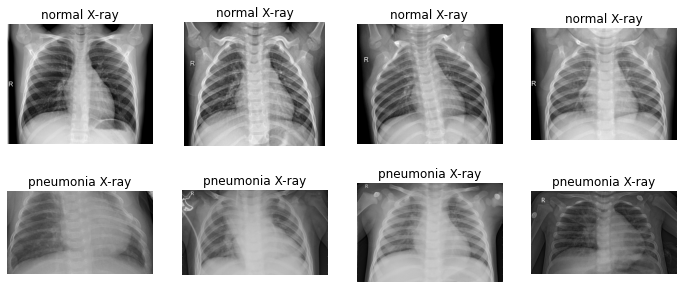

In [9]:
# 윗쪽은 일반인의 엑스레이 사진 / 아랫쪽은 폐렴 환자의 엑스레이 사진
# 폐렴 환자의 경우 사진에 하얀 부분이 더 많이 나타난다.
plt.figure(figsize=(12,5))
for i in range(4):
    plt.subplot(2,4,i+1)
    normal = cv2.imread(os.path.join(train_normal_dir, train_normal_fnames[i]))[:,:,::-1]
    plt.imshow(normal), plt.axis('off'), plt.title("normal X-ray")

    plt.subplot(2,4,i+5)
    pneumonia = cv2.imread(os.path.join(train_pneumonia_dir, train_pneumonia_fnames[i]))[:,:,::-1]
    plt.imshow(pneumonia), plt.axis('off'), plt.title("pneumonia X-ray")
# pneumonia.shape[:-1]
plt.show()

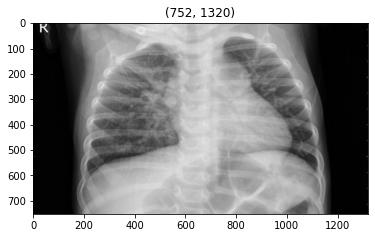

In [10]:
img = cv2.imread('/content/drive/MyDrive/dataset/chest_xray/train/PNEUMONIA/person1224_virus_2074.jpeg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

#### **데이터 부풀리기 (augmentation)**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,     # 이미지의 픽셀 값 조정
    rotation_range=20,     # 이미지 회전
    width_shift_range=0.1,  # 가로 방향으로 이동
    height_shift_range=0.1, # 세로 방향으로 이동
    shear_range=0.5,     # 이미지 굴절
    zoom_range=[0.8, 2.0],      # 이미지 확대
    horizontal_flip=True,   # 횡 방향으로 이미지 반전
    fill_mode='nearest'  # 이미지를 이동 또는 굴정 시켰을 때 빈 픽셀값에 대해 값을 채우는 방식
)

val_datagen = ImageDataGenerator(
    rescale=1/255.
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [12]:
img_height = 224
img_width = 224

#### **모델 구성**

In [13]:
train_data_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=32
)

val_data_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=32
)

test_data_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=32
)

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 2 classes.


#### **모델 설정**

In [14]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [16]:
a=3     # kernel_size에 숫자 넣으니까 오류 생겨서 미리 지정 / img_height 등도 마찬가지
model = Sequential([
    Conv2D(32, kernel_size=(a, a), padding='same', strides=(1, 1), input_shape=(img_height, img_width, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(a, a), padding='valid',  activation='relu'),
    MaxPooling2D(),
    Conv2D(128, kernel_size=(a, a), padding='valid', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [17]:
# 2가지 class에 속하기 때문에 binary_crossentropy로 설정함. (3개 이상인 경우 categorical_)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-xray-v1.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=3)

#### **모델 실행**

In [ ]:
hist = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
#    steps_per_epoch=300,        # 한번의 epoch에서 훈련에 사용할 batch의 갯수
#   validation_steps=300,        # 한번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 갯수
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
164/164 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.8186
Epoch 00001: val_loss improved from inf to -0.74846, saving model to best-xray-v1.h5
164/164 [==============================] - 621s 4s/step - loss: 0.3944 - accuracy: 0.8186 - val_loss: -0.7485 - val_accuracy: 0.4375
Epoch 2/50
164/164 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8549
Epoch 00002: val_loss improved from -0.74846 to -1.70667, saving model to best-xray-v1.h5
164/164 [==============================] - 655s 4s/step - loss: 0.3212 - accuracy: 0.8549 - val_loss: -1.7067 - val_accuracy: 0.4375
Epoch 3/50
164/164 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.8853
Epoch 00003: val_loss did not improve from -1.70667
164/164 [==============================] - 586s 4s/step - loss: 0.2716 - accuracy: 0.8853 - val_loss: -0.4561 - val_accuracy: 0.1875
Epoch 4/50
164/164 [==============================] - ETA: 0s - loss: 0.2310 - accurac

UnknownError: ignored

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

In [ ]:
# Final evaluation of the model
scores = model.evaluate(test_data_generator, verbose=0)
print("loss: %.2f" % scores[0])
print("acc: %.2f" % scores[1])

#### **학습과정 시각화 (1)**

In [ ]:
import numpy as np
y_acc = history.history['accuracy']
y_vloss = history.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

#### **모델 변화**
- batch_size를 32에서 100으로 늘림

In [31]:
del model2

In [32]:
train_data_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=100
)

val_data_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=100
)

test_data_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=100
)

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 2 classes.


In [33]:
a=3     
model2 = Sequential([
    Conv2D(32, kernel_size=(a, a), padding='same', strides=(1, 1), input_shape=(img_height, img_width, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(a, a), padding='valid',  activation='relu'),
    MaxPooling2D(),
    Conv2D(128, kernel_size=(a, a), padding='valid', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 128)     

In [34]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model_path = 'best-xray-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=3)

In [ ]:
hist = model2.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.7959 
Epoch 00001: val_loss improved from inf to -0.95690, saving model to best-xray-v2.h5
53/53 [==============================] - 835s 16s/step - loss: 0.4548 - accuracy: 0.7959 - val_loss: -0.9569 - val_accuracy: 0.4375
Epoch 2/50
17/53 [========>.....................] - ETA: 5:58 - loss: 0.3223 - accuracy: 0.8591

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

#### **학습과정 시각화 (2)**

In [ ]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()